In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Reshape, Dropout, LayerNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

import pandas as pd

In [2]:
df = pd.read_csv('AIerror_ONU16_15S_Cycle&Ai&Grantold.csv', usecols=[1], engine='python')
df.head()

,Ai
0,906
1,472
2,906
3,472
4,906


In [3]:
df = df.values
df = df.astype('float32')

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

30865 15203


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [18]:
# reshape into X=t and Y=t+1
look_back = 10 #16
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [8]:
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#print(trainX.shape)
#print(trainY.shape)
#print(testX.shape)
#print(testY.shape)

(30859, 1, 5)
(30859,)
(15197, 1, 5)
(15197,)


In [20]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 2, 5))
testX = np.reshape(testX, (testX.shape[0], 2, 5))
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(30854, 2, 5)
(30854,)
(15192, 2, 5)
(15192,)


In [9]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(40, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=165, verbose=1) #64 & 128

Epoch 1/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 2/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 4/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 6/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 7/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 8/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 9/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 10/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 11/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 12/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 13/20
188/188 [====

In [10]:
#batch_size = 64
from sklearn.metrics import mean_squared_error as mse
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mse(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mse(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# calculate root mean absolute error
trainScore2 = math.sqrt(mae(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMAE' % (trainScore2))
testScore2 = math.sqrt(mae(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMAE' % (testScore2))

Train Score: 19875.56 RMSE
Test Score: 18830.62 RMSE
Train Score: 97.62 RMAE
Test Score: 96.41 RMAE


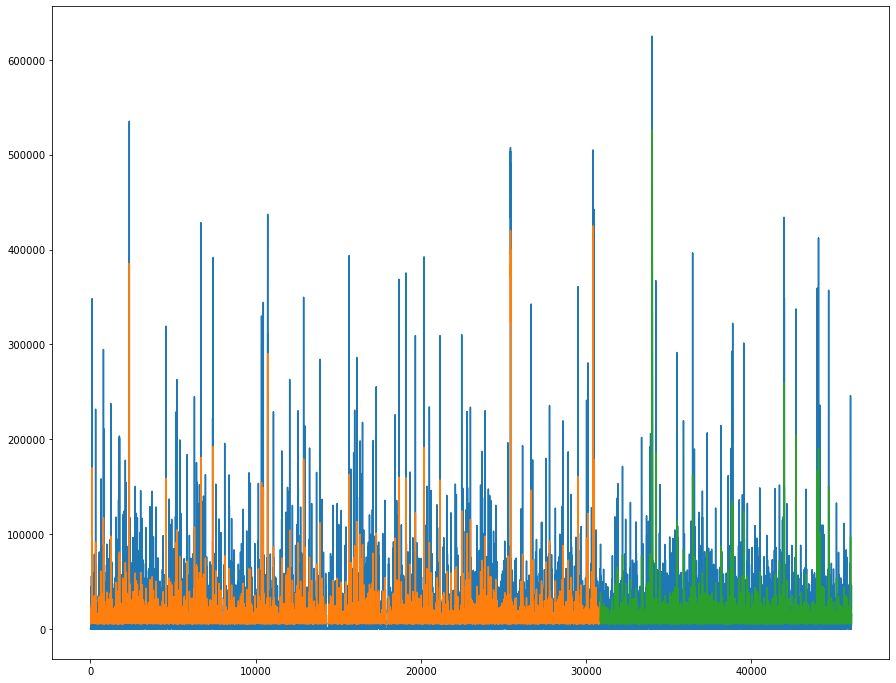

In [14]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15, 12))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40)                7360      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 7,401
Trainable params: 7,401
Non-trainable params: 0
_________________________________________________________________
